## Experiments with sparse features (CO2) - how predictive might it be?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
# import datetime as datetime
import cPickle as pickle
%matplotlib notebook
plt.style.use('ggplot')

In [2]:
# from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier #, RandomForestClassifier, 
from sklearn.ensemble.partial_dependence import plot_partial_dependence, partial_dependence
from sklearn.grid_search import GridSearchCV

### function definitions

In [3]:
def score_printout(X_test, y_test, fittedModel):
    print "AUC-ROC Score of model: ", roc_auc_score(y_test, fittedModel.predict_proba(X_test)[:,1])
    print "Precision Score of model: ", precision_score(y_test, fittedModel.predict(X_test))
    print "Recall Score of model: ", recall_score(y_test, fittedModel.predict(X_test))

In [4]:
def make_feature_importance_plot(featuresAndImportances, numFeatures):
    topN = featuresAndImportances[:numFeatures]
    labels = [pair[0] for pair in topN]
    values = [pair[1] for pair in topN]
    ind = np.arange(len(values)+2)
    width = 0.35   
    plt.barh(range(numFeatures),values)
    ax = plt.subplot(111)
    ax.set_yticks(ind+width)
    ax.set_yticklabels(labels, rotation=0, size=12)
    plt.ylabel('Feature', size=20)
    plt.xlabel('Importance', size=20)
    plt.show()
    
# vertical bar chart:    
#     topN = featuresAndImportances[:numFeatures]
#     labels = [pair[0] for pair in topN]
#     values = [pair[1] for pair in topN]
#     ind = np.arange(len(values))
#     width = 0.35   
#     plt.bar(range(numFeatures), values, width=0.8)
#     ax = plt.subplot(111)
#     ax.set_xticks(ind+width)
#     ax.set_xticklabels(labels, rotation=60, size=12)
#     plt.xlabel('Feature', size=20)
#     plt.ylabel('Importance', size=20)
#     plt.show()

### read in data

In [5]:
# for RRT events
masterdf_rrt = pickle.load(open('RRT_modeling_table_13hr_raw.p', 'rb'))
# for non-rrt events
masterdf_nonrrt = pickle.load(open('NonRRT_modeling_table_13hr_raw.p', 'rb'))

### Look at summary statistics for numeric columns for rrt & non-rrt tables (35 cols)

In [6]:
masterdf_rrt.columns

Index([u'rrt_ce_id', u'encntr_id', u'event_end_dt_tm', u'timestart',
       u'timeend', u'age', u'sex', u'obese', u'smoker', u'prev_rrt', u'on_iv',
       u'bu-nal', u'DBP_mean', u'DBP_recent', u'SBP_mean', u'SBP_recent',
       u'HR_mean', u'HR_recent', u'MAP_mean', u'MAP_recent', u'temp_mean',
       u'temp_recent', u'SPO2_mean', u'SPO2_recent', u'RR_mean', u'RR_recent',
       u'pulse_mean', u'pulse_recent', u'CO2_mean', u'CO2_recent', u'GCS_mean',
       u'GCS_recent', u'anticoagulants', u'narcotics', u'narc-ans',
       u'antipsychotics', u'chemo', u'dialysis', u'race', u'rrt_reason'],
      dtype='object')

### We're going to focus on including CO2, to check how important that feature is.
### Drop other columns where there are significant nans: drop HR (heart rate; we have pulse rate instead) & GCS, which leaves us with 27 feature
### drop race too...not using in model

In [15]:
col_use = ['age', 'sex', 'obese', 'smoker', 'prev_rrt', 'on_iv', 'bu-nal', 'DBP_mean',
       'DBP_recent', 'SBP_mean', 'SBP_recent',
       'MAP_mean', 'MAP_recent', 'temp_mean', 'temp_recent', 'SPO2_mean',
       'SPO2_recent', 'RR_mean', 'RR_recent', 'pulse_mean', 'pulse_recent',
       'anticoagulants', 'narcotics', 'narc-ans', 'antipsychotics',
       'chemo', 'dialysis', 'CO2_mean', 'CO2_recent']

In [16]:
X_rrt = masterdf_rrt[col_use]
X_notrrt = masterdf_nonrrt[col_use]

### We need to deal with these nans before we can start modeling. (There should not be any nans in the modeling table)

In [17]:
# let's look at getting rid of the data rows where vitals signs are all nans
vitals_cols = ['DBP_mean', 'DBP_recent', # take the mean of all the measurements & the most recently observed point
            'SBP_mean', 'SBP_recent',
            'MAP_mean', 'MAP_recent', # mean arterial pressure
             'temp_mean', 'temp_recent',# temperature
             'SPO2_mean', 'SPO2_recent',
               'CO2_mean', 'CO2_recent',
            'RR_mean', 'RR_recent', # respiratory rate
            'pulse_mean', 'pulse_recent']

In [18]:
# Write out rows that are not all 0/NaNs across. (if all nans, remove this sample)
X_rrt = X_rrt.loc[np.where(X_rrt.ix[:, vitals_cols].sum(axis=1, skipna=True)!=0)[0]]
X_rrt = X_rrt.reset_index(drop=True)
X_notrrt = X_notrrt.loc[np.where(X_notrrt.ix[:, vitals_cols].sum(axis=1, skipna=True)!=0)[0]]
X_notrrt = X_notrrt.reset_index(drop=True)

In [19]:
# if 'obese' is Nan, then set the patient to be not obese.
X_rrt.loc[np.where(pd.isnull(X_rrt['obese']))[0], 'obese'] = 0
X_notrrt.loc[np.where(pd.isnull(X_notrrt['obese']))[0], 'obese'] = 0

In [27]:
np.where(~pd.isnull(X_notrrt['CO2_mean']))

(array([   6,    7,   10,   11,   12,   14,   16,   20,   21,   30,   31,
          33,   34,   36,   41,   45,   54,   57,   59,   60,   62,   63,
          68,   69,   70,   71,   73,   77,   78,   79,   81,   82,   92,
          95,   96,   97,   99,  100,  101,  104,  108,  111,  113,  115,
         121,  125,  128,  130,  131,  132,  139,  149,  151,  153,  154,
         158,  160,  161,  165,  166,  169,  170,  172,  173,  177,  180,
         181,  182,  183,  184,  189,  190,  191,  195,  198,  200,  201,
         205,  208,  210,  217,  226,  235,  239,  242,  247,  252,  257,
         258,  269,  270,  271,  275,  276,  277,  280,  284,  285,  287,
         288,  290,  297,  303,  304,  309,  311,  315,  317,  319,  324,
         328,  331,  334,  336,  338,  339,  343,  344,  345,  349,  351,
         352,  356,  357,  359,  361,  365,  371,  372,  375,  378,  382,
         385,  390,  391,  393,  395,  398,  399,  400,  401,  403,  405,
         406,  418,  423,  427,  429, 

In [28]:
# DROP THE ROWS WHERE CO2 IS NAN
X_notrrt = X_notrrt.ix[np.where(~pd.isnull(X_notrrt['CO2_mean']))[0]]
X_notrrt = X_notrrt.reset_index(drop=True)

In [35]:
X_rrt = X_rrt.ix[np.where(~pd.isnull(X_rrt['CO2_mean']))[0]]
X_rrt = X_rrt.reset_index(drop=True)

In [36]:
X_rrt.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1016.0,67.824803,16.474097,19.00,58.000,70.000000,80.0,98.000000
obese,1016.0,0.220472,0.414769,0.00,0.000,0.000000,0.0,1.000000
smoker,1016.0,0.095472,0.294011,0.00,0.000,0.000000,0.0,1.000000
prev_rrt,1016.0,0.163386,0.369899,0.00,0.000,0.000000,0.0,1.000000
on_iv,1016.0,0.748031,0.434357,0.00,0.000,1.000000,1.0,1.000000
bu-nal,1016.0,0.040354,0.196886,0.00,0.000,0.000000,0.0,1.000000
DBP_mean,1015.0,70.482009,11.923274,38.75,NaN,NaN,NaN,120.600000
DBP_recent,1015.0,69.972414,14.476848,9.00,NaN,NaN,NaN,147.000000
SBP_mean,1016.0,126.107455,23.892325,61.20,108.625,123.732143,142.0,207.388889
SBP_recent,1016.0,124.447835,27.482359,1.00,105.000,122.000000,142.0,228.000000


In [37]:
# # And similarly for all rows with significant nans:

X_notrrt = X_notrrt.ix[np.where(~pd.isnull(X_notrrt['pulse_mean']))[0]]
X_notrrt = X_notrrt.reset_index(drop=True)

X_rrt = X_rrt.ix[np.where(~pd.isnull(X_rrt['pulse_mean']))[0]]
X_rrt = X_rrt.reset_index(drop=True)

# X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['RR_mean'])!=True)[0]]
# X_notrrt = X_notrrt.reset_index(drop=True)
# X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['MAP_mean'])!=True)[0]]
# X_notrrt = X_notrrt.reset_index(drop=True)
# X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['temp_mean'])!=True)[0]]
# X_notrrt = X_notrrt.reset_index(drop=True)
# X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['SPO2_mean'])!=True)[0]]
# X_notrrt = X_notrrt.reset_index(drop=True)

In [39]:
X_rrt.head().T

,0,1,2,3,4
age,67,68,81,68,54
sex,M,F,M,F,F
obese,0,0,0,1,0
smoker,0,1,1,0,0
prev_rrt,0,1,0,0,0
on_iv,0,1,0,0,0
bu-nal,0,0,0,0,0
DBP_mean,70,56.2,51.3333,74.8571,85.5
DBP_recent,61,57,54,62,89
SBP_mean,154.875,89.3333,96.6667,163.5,151


### We'll impute missing values in X_rrt after combining that data with X_notrrt, and use the mean from each column after merging to fill the values.

In [40]:
# add labels to indicate positive or negative class
X_rrt['label'] = 1
X_notrrt['label'] = 0

# Combine the tables
XY = pd.concat([X_rrt, X_notrrt])
XY = XY.reset_index(drop=True)
y = XY.pop('label')
X = XY

# Fill nans with mean of columns
X = X.fillna(X.mean())

In [41]:
# map genders to 1/0
X['is_male'] = X['sex'].map({'M': 1, 'F': 0})
X.pop('sex')

0       M
1       F
2       M
3       F
4       F
5       F
6       M
7       M
8       M
9       F
10      F
11      M
12      F
13      M
14      M
15      M
16      M
17      M
18      M
19      M
20      M
21      M
22      M
23      M
24      M
25      F
26      F
27      F
28      F
29      M
       ..
1629    M
1630    M
1631    M
1632    M
1633    M
1634    M
1635    F
1636    M
1637    M
1638    M
1639    M
1640    F
1641    F
1642    M
1643    M
1644    M
1645    F
1646    M
1647    M
1648    F
1649    M
1650    F
1651    F
1652    M
1653    F
1654    F
1655    F
1656    F
1657    F
1658    F
Name: sex, dtype: object

In [43]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1659.0,66.040386,17.123131,19.000000,55.500000,67.000000,79.000000,105.000000
obese,1659.0,0.239904,0.427153,0.000000,0.000000,0.000000,0.000000,1.000000
smoker,1659.0,0.101266,0.301771,0.000000,0.000000,0.000000,0.000000,1.000000
prev_rrt,1659.0,0.086799,0.281626,0.000000,0.000000,0.000000,0.000000,1.000000
on_iv,1659.0,0.764919,0.424178,0.000000,1.000000,1.000000,1.000000,1.000000
bu-nal,1659.0,0.028933,0.167669,0.000000,0.000000,0.000000,0.000000,1.000000
DBP_mean,1659.0,71.287740,10.935608,38.750000,63.450000,70.750000,78.500000,120.600000
DBP_recent,1659.0,71.122437,13.096840,9.000000,62.000000,71.000000,80.000000,147.000000
SBP_mean,1659.0,127.186198,22.008920,61.200000,111.000000,125.500000,141.875000,207.388889
SBP_recent,1659.0,126.264617,24.766568,1.000000,109.000000,125.000000,143.000000,228.000000


# Modeling

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [45]:
print len(y_train)
print len(y_train[y_train]==1)

1161
1161


In [46]:
len(y_test[y_test==1])

297

In [47]:
def score_printout(X_test, y_test, fittedModel):
    print "AUC-ROC Score of model: ", roc_auc_score(y_test, fittedModel.predict_proba(X_test)[:,1])
    print "Precision Score of model: ", precision_score(y_test, fittedModel.predict(X_test))
    print "Recall Score of model: ", recall_score(y_test, fittedModel.predict(X_test))

In [48]:
def make_feature_importance_plot(featuresAndImportances, numFeatures):
    topN = featuresAndImportances[:numFeatures]
    labels = [pair[0] for pair in topN]
    values = [pair[1] for pair in topN]
    ind = np.arange(len(values))
    width = 0.35   
    plt.bar(range(numFeatures), values, width=0.8)
    ax = plt.subplot(111)
    ax.set_xticks(ind+width)
    ax.set_xticklabels(labels, rotation=60, size=12)
    plt.xlabel('Feature', size=20)
    plt.ylabel('Importance', size=20)
    plt.show()
  

## Gradient Boosting Classifier - Scaled & unscaled (with partial dependence plots)


## Grid search for best GBC

In [49]:
paramGrid = {'n_estimators': [100, 200, 300],
             'learning_rate': [0.1, 0.05, 0.01, 0.2],
             'max_depth': [3, 4, 5, 6],
             'min_samples_leaf': [1, 2],
             'subsample': [0.75, 1.0, 0.85],
             'loss': ['deviance'],
             'max_features': [None, 'auto']
            }

gs = GridSearchCV(GradientBoostingClassifier(), 
                  param_grid=paramGrid, 
                  scoring='roc_auc', 
                  n_jobs=-1, 
                  cv=5, 
                  verbose=10)

gs.fit(X_train, y_train)

# result:
# GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
#               max_depth=3, max_features=None, max_leaf_nodes=None,
#               min_samples_leaf=2, min_samples_split=2,
#               min_weight_fraction_leaf=0.0, n_estimators=300,
#               presort='auto', random_state=None, subsample=0.75, verbose=0,
#               warm_start=False)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_es

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.850681 -   0.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=3, score=0.803071 -   0.2s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.819749 -   0.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=3, score=0.836241 -   0.3s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=3, score=0.844887 -   0.4s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=3, sc

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.6s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.812975 -   0.7s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.814028 -   0.7s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.852713 -   0.7s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.845036 -   0.7s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=3, score=0.857335 -   0.7s
[CV]

[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    1.0s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=None, max_depth=3, score=0.839296 -   0.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=None, max_depth=3, score=0.834124 -   0.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=None, max_depth=3, score=0.831083 -   0.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=3, score=0.840414 -   0.2s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=None, max_depth=3, score=0.843080 -   0.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=3, s

[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    1.2s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=3, score=0.819023 -   0.7s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=3, score=0.823512 -   0.7s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=3, score=0.807171 -   0.8s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    1.6s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.849284 -   0.2s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.823135 -   0.3s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.865658 -   0.3s
[CV] loss=deviance, learning_rate=0.1, min_samples

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.9s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.865056 -   0.4s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.850701 -   0.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=4, score=0.811846 -   0.3s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_le

[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:    2.1s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3, score=0.834274 -   0.8s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3, score=0.842725 -   0.8s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, s

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.4s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=4, score=0.804711 -   0.7s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.797481 -   0.4s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.839595 -   0.4s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=4, score=0.804094 -   0.7s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.814857 -   0.4s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=4, sc

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:    2.8s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.799654 -   0.9s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.821705 -   1.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.786896 -   0.7s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.847719 -   1.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.858057 -   1.1s
[

[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    3.4s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4, score=0.801282 -   0.4s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4, score=0.830021 -   0.3s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4, score=0.813427 -   0.3s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4, score=0.855347 -   0.3s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_ra

[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:    3.7s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.803929 -   1.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.830436 -   1.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.853541 -   1.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf

[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    4.1s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=4, score=0.804922 -   0.4s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=4, score=0.837834 -   0.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=4, score=0.845707 -   0.4s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=4, score=0.849627 -   0.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5 
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:    4.6s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=4, score=0.822285 -   0.7s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=4, score=0.798301 -   0.8s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=4, score=0.851222 -   0.8s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.851819 -   0.5s
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    5.1s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=4, score=0.848315 -   1.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=4, score=0.821555 -   1.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=4, score=0.799419 -   1.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_sample

[Parallel(n_jobs=-1)]: Done 385 tasks      | elapsed:    5.8s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5, score=0.797779 -   1.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.799642 -   1.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5, score=0.845259 -   1.0s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=5, score=0.800089 -   1.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=5 
[CV]  loss=deviance, learni

[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    6.6s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=5, score=0.815609 -   1.6s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=None, max_depth=5, score=0.840638 -   1.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=None, max_depth=5, score=0.811286 -   1.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_le

[Parallel(n_jobs=-1)]: Done 449 tasks      | elapsed:    7.2s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=5, score=0.853309 -   1.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=5, score=0.819782 -   1.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, sub

[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:    7.9s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5, score=0.858005 -   1.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5, score=0.792859 -   1.6s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=5, score=0.793754 -   1.6s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5, score=0.849627 -   1.6s
[CV]  loss=deviance, learn

[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:    8.8s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=5, score=0.829187 -   1.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.855347 -   0.7s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.837985 -   0.8s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_l

[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    9.6s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.844129 -   0.6s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.792859 -   0.7s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.847746 -   0.7s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.850104 -   0.7s
[CV] loss=deviance, learni

[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:   11.3s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.801282 -   2.6s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=6, score=0.826911 -   2.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=6, score=0.814093 -   2.2s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=auto, max_depth=6 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_

[Parallel(n_jobs=-1)]: Done 626 tasks      | elapsed:   12.2s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.855397 -   2.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.833131 -   2.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.805754 -   2.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=6, score=0.802773 -   2.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=6 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=6 
[CV]  loss=deviance, learni

[Parallel(n_jobs=-1)]: Done 665 tasks      | elapsed:   13.3s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=6, score=0.814480 -   0.9s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=6, score=0.834572 -   0.8s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3, score=0.839893 -   0.3s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_

[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:   14.5s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=None, max_depth=3, score=0.838592 -   0.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=auto, max_depth=6, score=0.859347 -   1.7s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=auto, max_depth=6, score=0.806578 -   1.7s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=3, score=0.869271 -   0.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=auto, max_depth=6, score=0.800388 -   1.8s
[C

[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:   15.2s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.820802 -   0.7s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.867991 -   0.7s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=6, score=0.805978 -   2.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=auto, max_depth=6, score=0.837736 -   2.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=6, score=0.853906 -   2.1s

[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   15.7s


[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.827275 -   0.3s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.863250 -   0.3s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.841171 -   0.3s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, mi

[Parallel(n_jobs=-1)]: Done 829 tasks      | elapsed:   16.2s


[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.812825 -   0.3s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.834421 -   0.3s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.853165 -   0.3s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, mi

[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:   16.7s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=4, score=0.839730 -   0.3s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.849135 -   0.4s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.864002 -   0.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=4, score=0.796512 -   0.4s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=4, score=0.838998 -   0.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4

[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed:   17.4s


[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.827822 -   1.0s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.785555 -   1.1s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.808959 -   1.1s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.849508 -   1.1s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.814252 -   

[Parallel(n_jobs=-1)]: Done 962 tasks      | elapsed:   18.1s


[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4, score=0.858659 -   0.4s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4, score=0.865432 -   0.3s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4, score=0.840716 -   0.3s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4, score=0.848756 -   0.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=4 
[CV] loss=deviance, le

[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:   18.9s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4, score=0.835027 -   0.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4, score=0.863250 -   0.4s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=4, score=0.848688 -   0.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_

[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   19.7s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.816362 -   0.6s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.804636 -   0.6s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.864002 -   0.5s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.840944 -   0.5s
[CV] loss=deviance, 

[Parallel(n_jobs=-1)]: Done 1105 tasks      | elapsed:   20.8s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=5, score=0.871002 -   0.6s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=5, score=0.809889 -   1.3s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=5, score=0.840033 -   1.3s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5, score=0.796810 -   1.0s
[CV] loss=deviance

[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:   21.9s


[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=5, score=0.838178 -   0.6s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=5, score=0.836544 -   0.6s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=5, score=0.857906 -   0.7s
[CV] loss=deviance, learning_rate=0.05, min

[Parallel(n_jobs=-1)]: Done 1205 tasks      | elapsed:   23.0s


[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=5, score=0.795915 -   0.7s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=5, score=0.836317 -   0.7s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5, score=0.853993 -   1.6s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5, score=0.834199 -   1.6s
[CV] loss=deviance

[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:   24.6s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=5, score=0.863968 -   1.6s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=5, score=0.838896 -   1.6s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=5, score=0.812373 -   1.7s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=5, score=0.861142 -   1.6s
[CV] loss=deviance

[Parallel(n_jobs=-1)]: Done 1309 tasks      | elapsed:   26.5s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6, score=0.845259 -   0.9s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=6, score=0.862873 -   1.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=None, max_depth=6, score=0.841085 -   1.4s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6, score=0.794350 -   0.9s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6 
[CV] loss=deviance,

[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   27.9s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6, score=0.798151 -   0.7s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6, score=0.852337 -   1.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6, score=0.801058 -   1.5s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=auto, max_depth=6, score=0.830856 -   1.3s
[CV] loss=deviance, 

[Parallel(n_jobs=-1)]: Done 1417 tasks      | elapsed:   29.7s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=6, score=0.843826 -   1.5s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=6, score=0.794126 -   1.5s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=6, score=0.853014 -   1.5s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, mi

[Parallel(n_jobs=-1)]: Done 1472 tasks      | elapsed:   30.5s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=6, score=0.804934 -   2.1s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=6, score=0.857229 -   2.3s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=6, score=0.857906 -   2.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=6, score=0.839882 -   2.3s
[CV]  loss=deviance,

[Parallel(n_jobs=-1)]: Done 1529 tasks      | elapsed:   31.1s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=3, score=0.797853 -   0.8s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.805493 -   0.7s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=3, score=0.828414 -   0.8s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=3, score=0.819598 -   0.8s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.817127 -   0.7s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_dep

[Parallel(n_jobs=-1)]: Done 1586 tasks      | elapsed:   31.9s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=3, score=0.846316 -   0.6s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.816287 -   0.4s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estima

[Parallel(n_jobs=-1)]: Done 1645 tasks      | elapsed:   32.7s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.799717 -   1.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.787791 -   1.1s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.812222 -   1.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.804696 -   1.1s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.821480 -   

[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   33.7s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.834383 -   1.1s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.838402 -   1.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.787567 -   1.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.846253 -   1.1s
[CV]  loss=deviance, 

[Parallel(n_jobs=-1)]: Done 1765 tasks      | elapsed:   34.9s


[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.794275 -   0.6s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=4, score=0.856326 -   0.8s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.808949 -   0.6s
[CV] loss=deviance, learning_rate=0.01, min

[Parallel(n_jobs=-1)]: Done 1826 tasks      | elapsed:   36.1s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.795394 -   1.5s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.858809 -   1.6s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.838178 -   1.7s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.845115 -   1.7s
[CV] loss=deviance,

[Parallel(n_jobs=-1)]: Done 1889 tasks      | elapsed:   37.6s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.844888 -   1.6s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=5, score=0.857455 -   1.6s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.859411 -   1.6s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.836389 -   1.6s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.822533 -   

[Parallel(n_jobs=-1)]: Done 1952 tasks      | elapsed:   39.3s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.796586 -   0.9s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=5, score=0.791965 -   1.3s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.832961 -   0.9s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.843456 -   0.7s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=6 
[CV] loss=deviance,

[Parallel(n_jobs=-1)]: Done 2017 tasks      | elapsed:   41.1s


[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=6, score=0.815760 -   1.8s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.799568 -   2.4s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=6, score=0.794648 -   1.6s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.811997 -   2.4s
[CV] loss=deviance

[Parallel(n_jobs=-1)]: Done 2082 tasks      | elapsed:   43.7s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6, score=0.839123 -   0.7s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=6 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=auto, max_depth=6, score=0.853541 -   1.5s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6, score=0.846253 -   1.7s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6, score=0.816211 -   0.9s
[CV] loss=deviance

[Parallel(n_jobs=-1)]: Done 2149 tasks      | elapsed:   45.5s


[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.786374 -   0.6s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.836315 -   0.6s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=6, score=0.839882 -   1.7s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.831842 -   0.5s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, lea

[Parallel(n_jobs=-1)]: Done 2216 tasks      | elapsed:   46.5s


[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3, score=0.807342 -   0.3s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=3, score=0.864937 -   0.2s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=3, score=0.850230 -   0.2s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=3, score=0.814017 -   0.2s
[CV]  loss=deviance, learning_r

[Parallel(n_jobs=-1)]: Done 2285 tasks      | elapsed:   47.2s


[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3, score=0.808885 -   0.7s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3, score=0.840191 -   0.8s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3, score=0.797254 -   0.7s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf

[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed:   48.1s


[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=4, score=0.799642 -   0.7s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.854949 -   0.4s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.852412 -   0.4s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=4, score=0.805298 -   0.3s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.840713 -   0.7s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, s

[Parallel(n_jobs=-1)]: Done 2425 tasks      | elapsed:   49.2s


[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.805605 -   1.1s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4, score=0.854875 -   0.7s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4, score=0.789058 -   0.7s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.806879 -   1.0s
[CV] loss=deviance, learnin

[Parallel(n_jobs=-1)]: Done 2496 tasks      | elapsed:   50.6s


[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=5, score=0.798151 -   0.5s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.822816 -   0.5s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=5, score=0.843992 -   0.5s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.846542 -   0.5s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_

[Parallel(n_jobs=-1)]: Done 2569 tasks      | elapsed:   52.4s


[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=5, score=0.823211 -   1.6s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=5, score=0.822740 -   1.6s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5, score=0.842703 -   1.1s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=None, max_depth=5, score=0.808328 -   1.0s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=5, score=0.789505 -   1.7s
[CV

[Parallel(n_jobs=-1)]: Done 2642 tasks      | elapsed:   53.7s


[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=5, score=0.826001 -   0.6s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=5, score=0.839542 -   0.6s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=5, score=0.798224 -   0.6s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=5, score=0.829718 -   0.6s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV] loss=deviance, learni

[Parallel(n_jobs=-1)]: Done 2717 tasks      | elapsed:   56.0s


[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=6, score=0.833131 -   1.5s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=6, score=0.851208 -   1.5s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=6, score=0.796213 -   0.8s
[CV]  loss=deviance, learning_rate=0.2, min_samples

[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  1.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'loss': ['deviance'], 'learning_rate': [0.1, 0.05, 0.01, 0.2], 'min_samples_leaf': [1, 2], 'n_estimators': [100, 200, 300], 'subsample': [0.75, 1.0, 0.85], 'max_features': [None, 'auto'], 'max_depth': [3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=10)

In [50]:
gs.best_estimator_

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=4, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.75, verbose=0,
              warm_start=False)

In [40]:
# gss.best_estimator_

In [51]:
gbc = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=4, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.75, verbose=0,
              warm_start=False)
gbc.fit(X_train, y_train)
score_printout(X_test, y_test, gbc)
print classification_report(y_test, gbc.predict(X_test))
confusion_matrix(y_test, gbc.predict(X_test))

AUC-ROC Score of model:  0.878101077106
Precision Score of model:  0.835087719298
Recall Score of model:  0.801346801347
             precision    recall  f1-score   support

          0       0.72      0.77      0.74       201
          1       0.84      0.80      0.82       297

avg / total       0.79      0.79      0.79       498



array([[154,  47],
       [ 59, 238]])

<IPython.core.display.Javascript object>


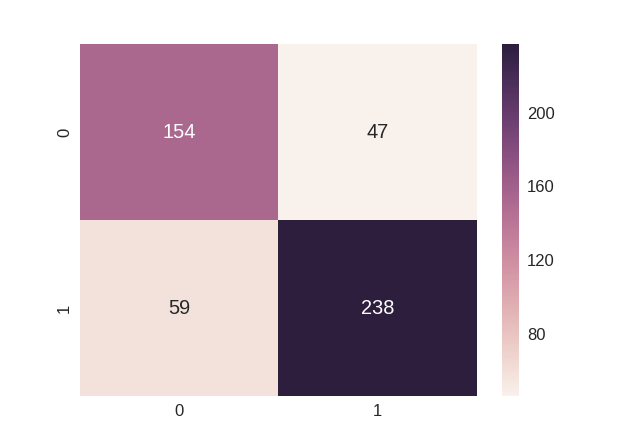

In [52]:
# Let's plot the confusion matrix so it's a little clearer
plt.figure()
sns.set(font_scale=1.5)
sns.heatmap(confusion_matrix(y_test, gbc.predict(X_test)), annot=True, fmt='d')

## Let's look at the most important features in this model

In [53]:
gbcRankedFeatures = sorted(zip(X.columns, gbc.feature_importances_), 
                          key=lambda pair: pair[1], 
                          reverse=False)

<IPython.core.display.Javascript object>


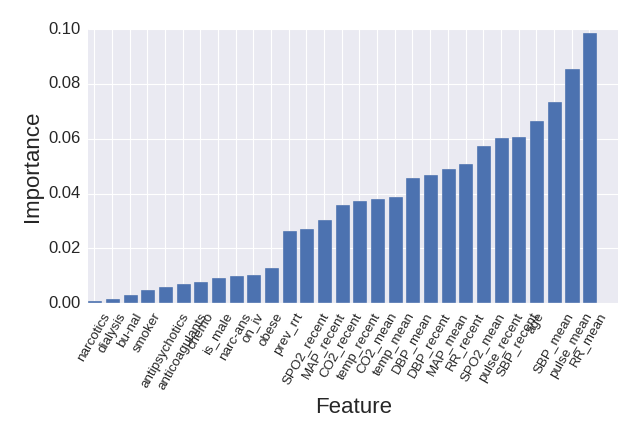

In [61]:
plt.figure()
make_feature_importance_plot(gbcRankedFeatures, 29)
plt.tight_layout()

### Let's look a partial dependence plots
#### If the partial dependence is high, then the model for that given value of that given feature is more likely to predict an rrt result.
#### Will not show more complex interactions -- if importance is high but partial dependence is marginal, this may be due to interactions

<IPython.core.display.Javascript object>


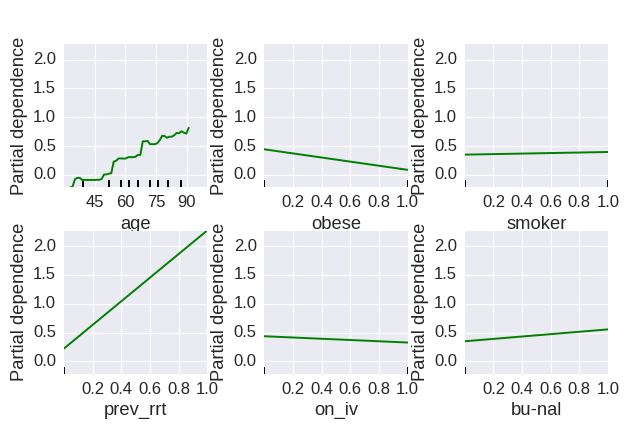

In [55]:
fig, axs = plot_partial_dependence(gbc, X_train, range(0, 6, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


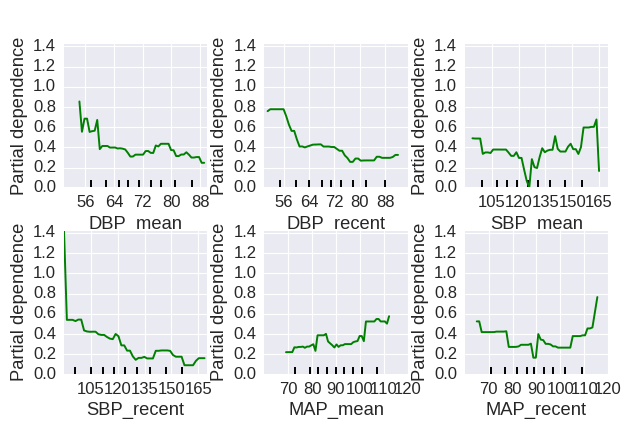

In [56]:
fig, axs = plot_partial_dependence(gbc, X_train, range(6, 12, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


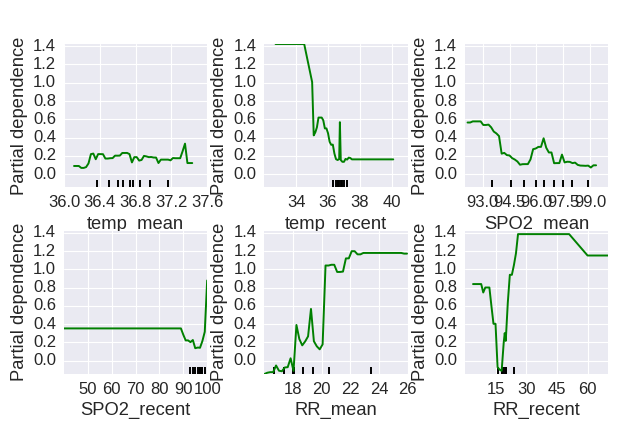

In [48]:
fig, axs = plot_partial_dependence(gbc, X_train, range(12, 18, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


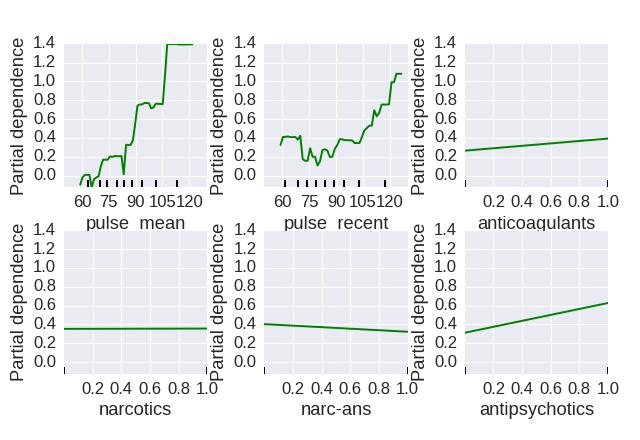

In [57]:
fig, axs = plot_partial_dependence(gbc, X_train, range(18, 24, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


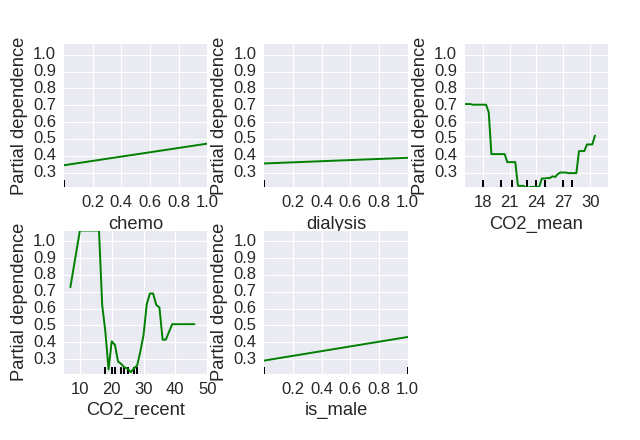

In [58]:
fig, axs = plot_partial_dependence(gbc, X_train, range(24, 29, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

## Use 3-D plot to investigate feature interactions for weak partial dependence plots... (weak effect may be masked by stronger interaction with other features)

In [59]:
names = X_train.columns
zip(range(len(names)), names)

[(0, 'age'),
 (1, 'obese'),
 (2, 'smoker'),
 (3, 'prev_rrt'),
 (4, 'on_iv'),
 (5, 'bu-nal'),
 (6, 'DBP_mean'),
 (7, 'DBP_recent'),
 (8, 'SBP_mean'),
 (9, 'SBP_recent'),
 (10, 'MAP_mean'),
 (11, 'MAP_recent'),
 (12, 'temp_mean'),
 (13, 'temp_recent'),
 (14, 'SPO2_mean'),
 (15, 'SPO2_recent'),
 (16, 'RR_mean'),
 (17, 'RR_recent'),
 (18, 'pulse_mean'),
 (19, 'pulse_recent'),
 (20, 'anticoagulants'),
 (21, 'narcotics'),
 (22, 'narc-ans'),
 (23, 'antipsychotics'),
 (24, 'chemo'),
 (25, 'dialysis'),
 (26, 'CO2_mean'),
 (27, 'CO2_recent'),
 (28, 'is_male')]

In [63]:
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


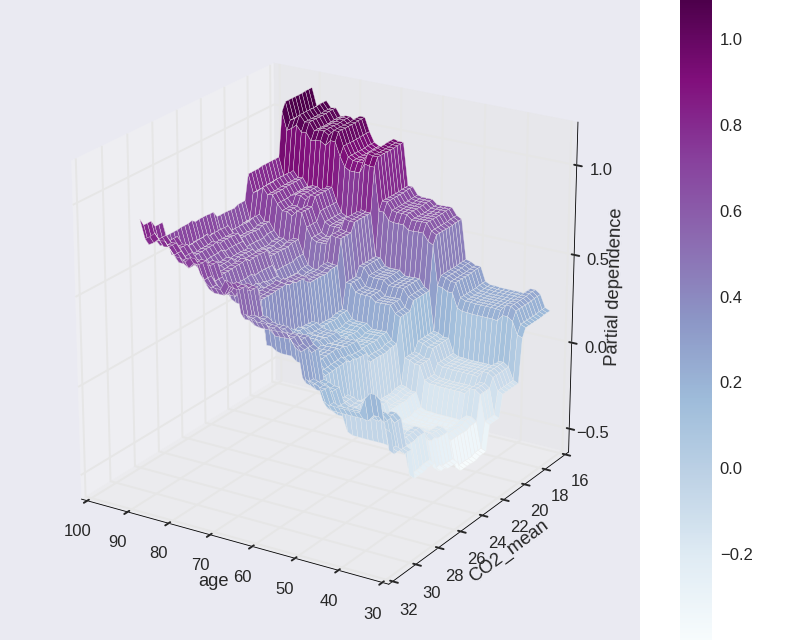

In [64]:
# not all features may work for this viz
fig = plt.figure(figsize=(10,8))
target_feature = (0, 26)  # <--  change the two numbers here to determine what to plot up
pdp, (x_axis, y_axis) = partial_dependence(gbc, target_feature, X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('')
plt.subplots_adjust(top=0.9)

plt.show()

In [69]:
# Return probabilities from the model, rather than predictions
y_proba = gbc.predict_proba(X_test)


pred_probs = pd.DataFrame(data=y_proba[:,1], columns =["model_probability_of_rrt"], index = X_test.index)


In [70]:
pred_probs['model_probability_of_rrt'] = pd.to_numeric(pred_probs.model_probability_of_rrt)

<IPython.core.display.Javascript object>


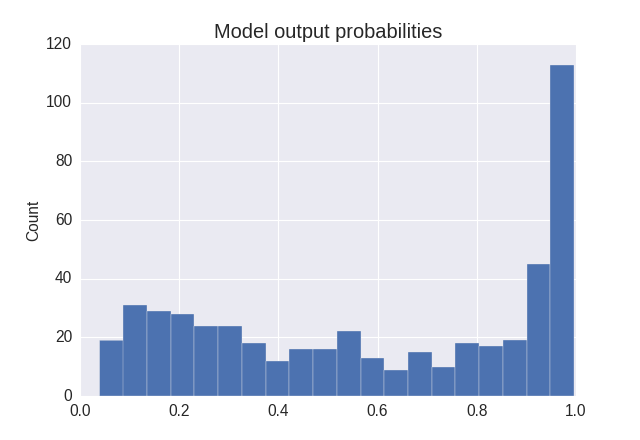

In [71]:
pred_probs.hist(bins = 20, xlabelsize = 16, ylabelsize=16)
plt.tick_params(labelsize=14)
plt.title("Model output probabilities")
plt.ylabel('Count', fontsize=14)

### We see that although we see more values close to 0 and 1, we also see that the model outputs a full range of probabilities, which would translate well into risk scores.


### Patient Risk Score = model probability * 10
The score should be rounded to whole values to give the sense that this is not an exact measure.

In [72]:
pred_probs['score'] = pred_probs['model_probability_of_rrt'].apply(lambda x: int(round(x*10.0, 0)))

In [73]:
pred_probs.head()

,model_probability_of_rrt,score
642,0.567736,6
1353,0.783027,8
792,0.205082,2
480,0.989041,10
1470,0.478017,5


In [74]:
pred_probs.score.value_counts()

10    111
9      68
2      56
1      56
3      47
5      38
8      34
4      34
7      27
6      24
0       3
Name: score, dtype: int64

### save out model

In [65]:
# from sklearn.externals import joblib
# # # joblib.dump(gbc, 'gbc_base.pkl') # note - if left uncompressed, this writes a whole lot of supporting numpy files.
# joblib.dump(gbc, 'gbc_base.compressed', compress=True)  

# # to unpack: joblib.load(filename)

['gbc_base.compressed']

### save out modeling table

In [414]:
# create combined data frame including modeling table, rrt label, and proability associated with result
# df = pd.concat([X_test, pred_probs, y_test],axis=1, join_axes=[X_test.index])

In [418]:
# May need to rename columns to get rid of dash in name...
# df.rename(columns={'bu-nal': 'bu_nal', 'narc-ans': 'narc_ans'}, inplace=True)